# **IMDB Movie Review Sentiment**

##### Problem Description
The dataset is the Large Movie Review Dataset often referred to as the IMDB dataset.

The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly polar moving reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.

The data was collected by Stanford researchers and was used in a 2011 paper(https://ai.stanford.edu/~amaas/data/sentiment/) where a split of 50/50 of the data was used for training and test. An accuracy of 88.89% was achieved.

In [106]:
import numpy as np  
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
tf.test.gpu_device_name()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

In [107]:
#fix random seed for reproducibility
random_state= 42
np.random.seed(random_state)

#### **Load the IMDB Dataset With Keras**
Keras provides access to the IMDB dataset built-in.

The keras.datasets.imdb.load_data() allows you to load the dataset in a format that is ready for use in neural network and deep learning models.

The words have been replaced by integers that indicate the absolute popularity of the word in the dataset. Words were ordered by frequency then assigned integers based on that frequency. The sentences in each review are therefore comprised of a sequence of integers.

Calling imdb.load_data() the first time will download the IMDB dataset to your computer and store it in your home directory under ~/.keras/datasets/imdb.pkl as a 32 megabyte file.

Usefully, the imdb.load_data() provides additional arguments including the number of top words to load (where words with a lower integer are marked as zero in the returned data), the number of top words to skip (to avoid the “the”‘s) and the maximum length of reviews to support.

Let’s load the dataset and calculate some properties of it. We will start off by loading some libraries and loading the entire IMDB dataset as a training dataset.

In [108]:
#Load the dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()
X = np.concatenate((X_train, X_test), axis= 0)
y = np.concatenate((y_train, y_test), axis= 0)

In [109]:
print("Training data : ")
print(X.shape)
print(y.shape)

Training data : 
(50000,)
(50000,)


In [110]:
# Summarize number of classes
print("Classes:", np.unique(y))

Classes: [0 1]


In [111]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [112]:
print(y_train[0])

1


Next we can get an idea of the total number of unique words in the dataset.

In [113]:
print("Number of words: ", len(np.unique(np.hstack(X))))

Number of words:  88585


Interestingly, we can see that there are just under 100,000 words across the entire dataset.

Finally, we can get an idea of the average review length.

In [114]:
print("Review Length:")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

Review Length:
Mean 234.76 words (172.911495)


Looking at a box and whisker plot for the review lengths in words, we can probably see an exponential distribution that we can probably cover the mass of the distribution with a clipped length of 400 to 500 words.

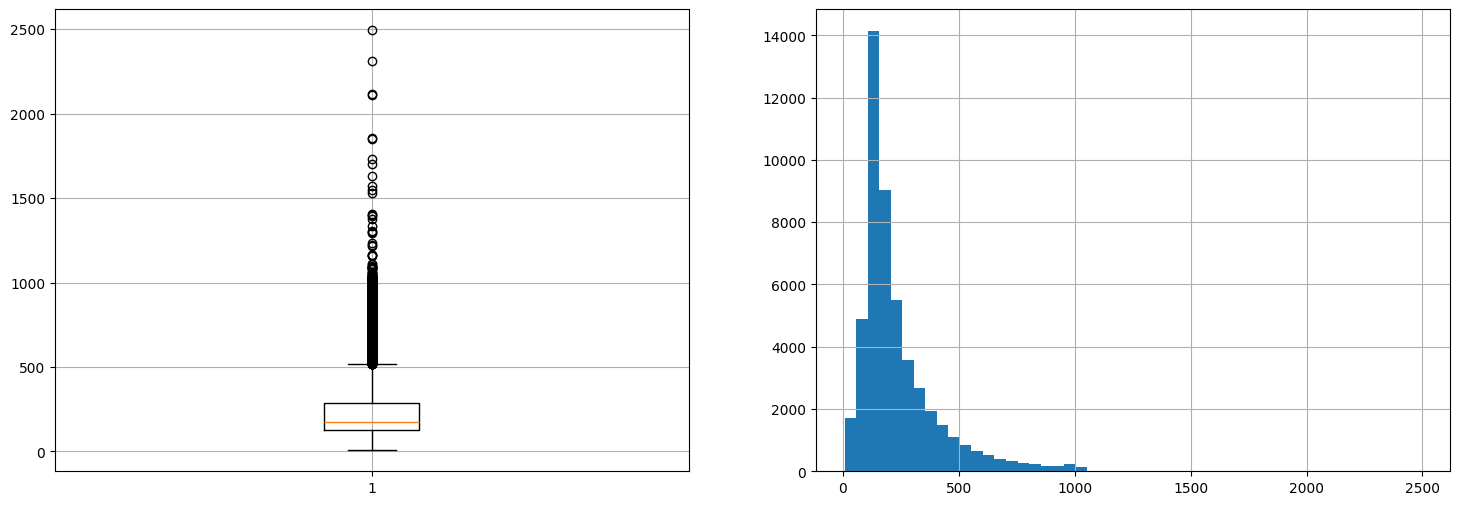

In [115]:
plt.figure(figsize= (18,6))

plt.subplot(121)
plt.boxplot(result)
plt.grid(which= 'major')

plt.subplot(122)
plt.hist(result, bins = 50)
plt.grid(which='major')


#### **Word Embeddings**
A recent breakthrough in the field of natural language processing is called word embedding.

This is a technique where words are encoded as real-valued vectors in a high-dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Discrete words are mapped to vectors of continuous numbers. This is useful when working with natural language problems with neural networks and deep learning models are we require numbers as input.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding Layer.

The layer takes arguments that define the mapping including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value that will be seen as an integer). The layer also allows you to specify the dimensionality for each word vector, called the output dimension.

We would like to use a word embedding representation for the IMDB dataset.

Let’s say that we are only interested in the first 5,000 most used words in the dataset. Therefore our vocabulary size will be 5,000. We can choose to use a 32-dimension vector to represent each word. Finally, we may choose to cap the maximum review length at 500 words, truncating reviews longer than that and padding reviews shorter than that with 0 values.

We would then use the Keras utility to truncate or pad the dataset to a length of 500 for each observation using the sequence.pad_sequences() function.

The first layer of our model would be an word embedding layer created using this Embedding class.

#### **Simple Multi-Layer Perceptron Model for the IMDB Dataset**

We will start off by developing a simple multi-layer perceptron model with a single hidden layer.

We will load the IMDB dataset. We will simplify the dataset on word embeddings. Only the top 5,000 words will be loaded.

We will also use a 70%/20%/10% split of the dataset into training, validation and test.

In [116]:
top_words = 5000

In [117]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=top_words)
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [118]:
print(X.shape)


(50000,)


We will bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews.

In [119]:
max_words = 500
X = sequence.pad_sequences(X, maxlen=max_words)

#### **Explicitly split the training, validation and test sets**


In [120]:
X_train, X_valid, X_test = X[:35000], X[35000:45000], X[45000:]
y_train, y_valid, y_test = y[:35000], y[35000:45000], y[45000:]

In [121]:
print('Train Samples:      {0}'.format(X_train.shape))
print('Validation Samples: {0}'.format(X_valid.shape))
print('Test Samples:       {0}'.format(X_test.shape))

Train Samples:      (35000, 500)
Validation Samples: (10000, 500)
Test Samples:       (5000, 500)


In [122]:
print('Train Samples:      {0}'.format(y_train.shape))
print('Validation Samples: {0}'.format(y_valid.shape))
print('Test Samples:       {0}'.format(y_test.shape))

Train Samples:      (35000,)
Validation Samples: (10000,)
Test Samples:       (5000,)


#### **Building the Model Architecture**

In [123]:
import keras.regularizers


model = Sequential()
model.add(Embedding(input_dim= top_words, output_dim=32, input_shape=(500,)))
model.add(Flatten())
model.add(Dense(256, activation= 'relu', kernel_regularizer=keras.regularizers.l2(0.2)))
model.add(Dense(1, activation= 'sigmoid'))

c:\Users\aksha\anaconda3\envs\sentiment\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [124]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 500, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,256,513 (16.24 MB)

 Trainable params: 4,256,513 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#### **Training the Model**

In [126]:
# Fit the model
from keras.callbacks import EarlyStopping
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid), 
                    epochs=10, 
                    batch_size=128, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    verbose=2).history

Epoch 1/10
274/274 - 22s - 80ms/step - accuracy: 0.5776 - loss: 2.9172 - val_accuracy: 0.8035 - val_loss: 0.6463
Epoch 2/10
274/274 - 20s - 75ms/step - accuracy: 0.8307 - loss: 0.5966 - val_accuracy: 0.8205 - val_loss: 0.6192
Epoch 3/10
274/274 - 21s - 75ms/step - accuracy: 0.8552 - loss: 0.5634 - val_accuracy: 0.8535 - val_loss: 0.5728
Epoch 4/10
274/274 - 21s - 76ms/step - accuracy: 0.8669 - loss: 0.5435 - val_accuracy: 0.8572 - val_loss: 0.5477
Epoch 5/10
274/274 - 21s - 76ms/step - accuracy: 0.8677 - loss: 0.5514 - val_accuracy: 0.8574 - val_loss: 0.5890
Epoch 6/10
274/274 - 21s - 77ms/step - accuracy: 0.8744 - loss: 0.5366 - val_accuracy: 0.8591 - val_loss: 0.5507
Epoch 7/10
274/274 - 21s - 77ms/step - accuracy: 0.8751 - loss: 0.5416 - val_accuracy: 0.8633 - val_loss: 0.5418
Epoch 8/10
274/274 - 21s - 76ms/step - accuracy: 0.8808 - loss: 0.5258 - val_accuracy: 0.8489 - val_loss: 0.6124
Epoch 9/10
274/274 - 21s - 78ms/step - accuracy: 0.8793 - loss: 0.5366 - val_accuracy: 0.8440 - 

#### **Evaluating the Model on Test Set**

In [127]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Test Accuracy: 86.04%


#### **Plotting Training vs Validation Loss & Accuracy**

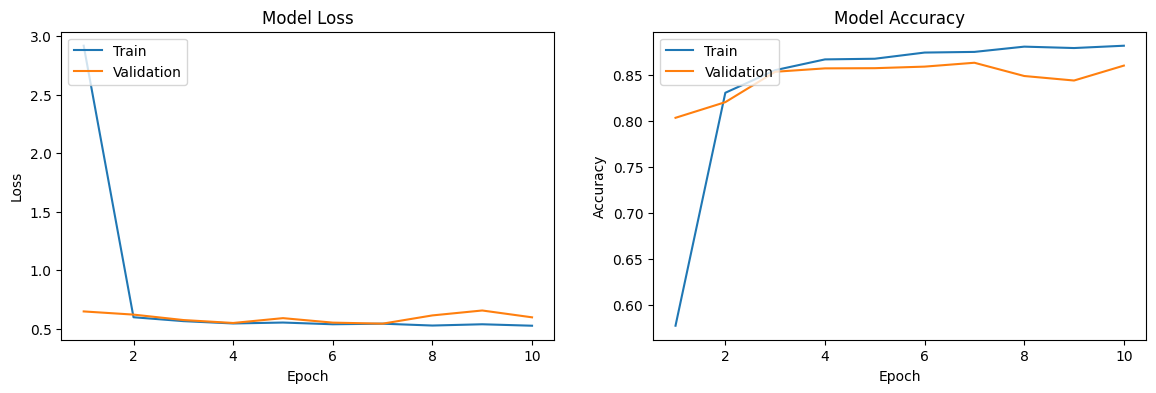

In [128]:
plt.figure(figsize=(14, 4))

# Loss
plt.subplot(121)
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
if 'val_loss' in history:
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'] if 'val_loss' in history else ['Train'], loc='upper left')

# Accuracy
plt.subplot(122)
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
if 'val_accuracy' in history:
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'] if 'val_accuracy' in history else ['Train'], loc='upper left')

plt.show()


#### **One-Dimensional Convolutional Neural Network Model for the IMDB Dataset**

Convolutional neural networks were designed to honor the spatial structure in image data whilst being robust to the position and orientation of learned objects in the scene.

This same principle can be used on sequences, such as the one-dimensional sequence of words in a movie review. The same properties that make the CNN model attractive for learning to recognize objects in images can help to learn structure in paragraphs of words, namely the techniques invariance to the specific position of features.

Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

In [144]:
# CNN for the IMDB problem
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from tensorflow.keras import regularizers


In [145]:
# fix random seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [146]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000

In [147]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=top_words)


In [150]:
#Pad with explicit dtype to avoid object arrays
seq_len = 500
X_train = sequence.pad_sequences(X_train, maxlen=seq_len, dtype='int32')
X_test = sequence.pad_sequences(X_test, maxlen=seq_len, dtype='int32')

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0).astype('float32')  #

In [152]:
print(X.shape)

(50000, 500)


In [153]:
X_train, X_valid, X_test = X[:35000], X[35000:45000], X[45000:]
y_train, y_valid, y_test = y[:35000], y[35000:45000], y[45000:]

In [154]:
print('Train Samples:      {0}'.format(X_train.shape))
print('Validation Samples: {0}'.format(X_valid.shape))
print('Test Samples:       {0}'.format(X_test.shape))

Train Samples:      (35000, 500)
Validation Samples: (10000, 500)
Test Samples:       (5000, 500)


In [155]:
print('Train Samples:      {0}'.format(y_train.shape))
print('Validation Samples: {0}'.format(y_valid.shape))
print('Test Samples:       {0}'.format(y_test.shape))

Train Samples:      (35000,)
Validation Samples: (10000,)
Test Samples:       (5000,)


#### **Building the Model Architecture**

We can now define our convolutional neural network model. This time, after the Embedding input layer, we insert a Conv1D layer. This convolutional layer has 32 feature maps and reads embedded word representations 3 vector elements of the word embedding at a time.

The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [156]:
# create the model
model = Sequential([
    Input(shape=(max_words,)),
    Embedding(input_dim=top_words, output_dim=32),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.1)),
    Dense(1, activation='sigmoid')
])

In [157]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 500, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     2,048,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,211,617 (8.44 MB)

 Trainable params: 2,211,617 (8.44 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [159]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/10
274/274 - 16s - 59ms/step - accuracy: 0.5779 - loss: 2.3254 - val_accuracy: 0.8288 - val_loss: 0.5085
Epoch 2/10
274/274 - 15s - 56ms/step - accuracy: 0.8714 - loss: 0.4011 - val_accuracy: 0.8629 - val_loss: 0.4096
Epoch 3/10
274/274 - 15s - 54ms/step - accuracy: 0.8980 - loss: 0.3368 - val_accuracy: 0.8935 - val_loss: 0.3410
Epoch 4/10
274/274 - 15s - 54ms/step - accuracy: 0.9068 - loss: 0.3106 - val_accuracy: 0.8845 - val_loss: 0.3506
Epoch 5/10
274/274 - 15s - 54ms/step - accuracy: 0.9123 - loss: 0.2944 - val_accuracy: 0.8849 - val_loss: 0.3403
Epoch 6/10
274/274 - 15s - 56ms/step - accuracy: 0.9196 - loss: 0.2752 - val_accuracy: 0.8889 - val_loss: 0.3566
Epoch 7/10
274/274 - 15s - 56ms/step - accuracy: 0.9242 - loss: 0.2615 - val_accuracy: 0.8920 - val_loss: 0.3334
Epoch 8/10
274/274 - 16s - 58ms/step - accuracy: 0.9291 - loss: 0.2497 - val_accuracy: 0.8898 - val_loss: 0.3374
Epoch 9/10
274/274 - 15s - 56ms/step - accuracy: 0.9300 - loss: 0.2468 - val_accuracy: 0.8798 - 

#### **Plotting Training vs Validation Loss & Accuracy**

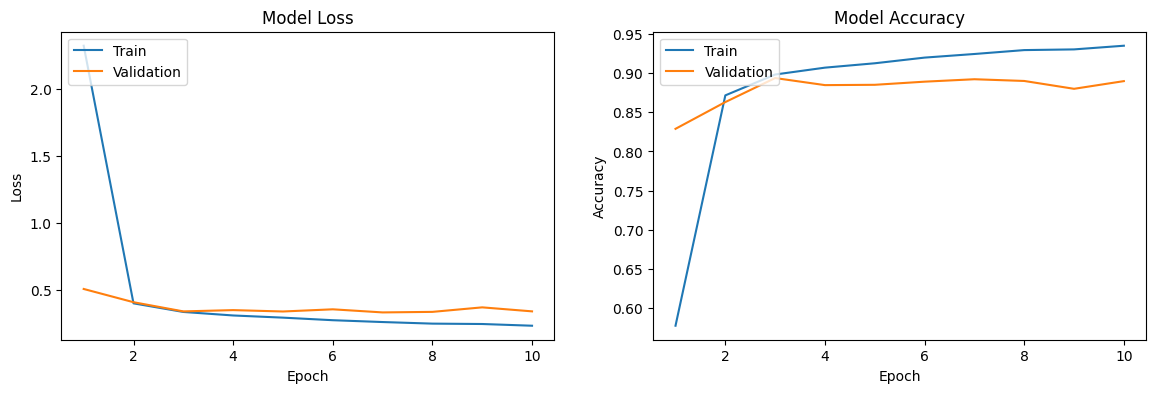

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))

# summarize history for loss
plt.subplot(121)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# summarize history for accuracy
plt.subplot(122)
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


#### **Evaluating the Model on Test Set**

In [162]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Test Accuracy: 88.82%
